# Dreamclinic Client Churn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import datetime as dt
from sklearn.linear_model import LogisticRegression

In [2]:
client_df = pd.read_excel("~/dales_work/clinic_services_8-1-2016_to_8-3-2019.xlsx")


In [3]:
client_df.drop('Name_Full', axis=1, inplace=True)

In [4]:
# remove rows where HrsWorked = 0 because they are just used by the front desk 
# staff
client_df  = client_df[client_df['HrsWorked'] != 0]

# fill NaN values in 'Service_Category with 'Massage'
client_df['Service_Category'].fillna(value='Massage', inplace=True)

# remove white space from Therapist names
client_df['Therapist'] = client_df['Therapist'].str.strip()

# make all therapist names lowercase to avoid typos in data entry
client_df['Therapist'] = client_df['Therapist'].str.lower()

# find and replace nicknames with domain knowledge
client_df = client_df.replace('abby thomson', 
                              'abigail thomson')

#Drop Address_City and Addres_State Columns from Dataframe
client_df.drop(['Address_City', 
                'Address_State', 
                'Invoice_Category'], 
               axis=1, 
               inplace=True)

# Drop rows without a clientID
client_df.dropna(subset=['clientID'], inplace=True)

In [5]:
#Order TransactionDate column by month
months = client_df.TransactionDate.dt.to_period("M")

g = client_df.groupby(months)b

In [6]:
#Count unique clients by month and drop/rename columns to reflect new aggredated DateFrame
client_count_df = g.nunique() 

client_count_df.drop('TransactionDate', 
                     axis=1, 
                     inplace= True)

client_count_df.reset_index(inplace=True)

client_count_df["client_count"] = client_count_df['clientID']

client_count_df.drop('clientID', axis=1, inplace=True)

client_count_df['TransactionDate'] = client_count_df['TransactionDate'].astype('str')

client_count_df.rename(columns={"clientID" : "unique_client_count", 
                                   "Therapist" : "therapists_employed", 
                                   "Zipcode" :"zipcodes_reached"}, inplace=True)



client_count_df.drop(["HrsWorked"], axis=1, inplace=True)

client_count_df.drop(['Service_Category'],axis=1,  inplace=True)

# Graph of unique client counts per month from August, 2016

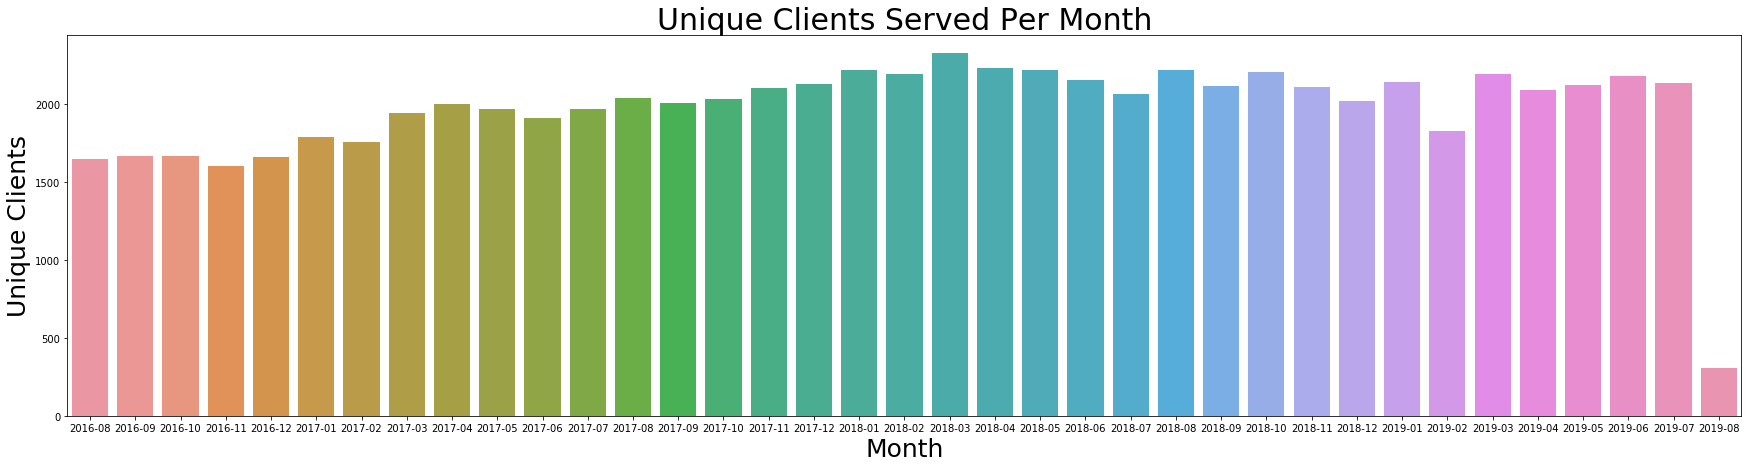

In [59]:
# the dip in Febuary of 2019 is explained by the 1 week snow closure of Seattle
x = client_count_df['TransactionDate']
y = client_count_df['client_count']


fig, ax = plt.subplots(figsize=(30,7))
plt.title("Unique Clients Served Per Month", fontsize= 30)


sns.barplot(x= client_count_df['TransactionDate'], 
             y= client_count_df['client_count'],
             ax=ax)
plt.xlabel('Month', fontsize=25)
plt.ylabel('Unique Clients', fontsize=25);


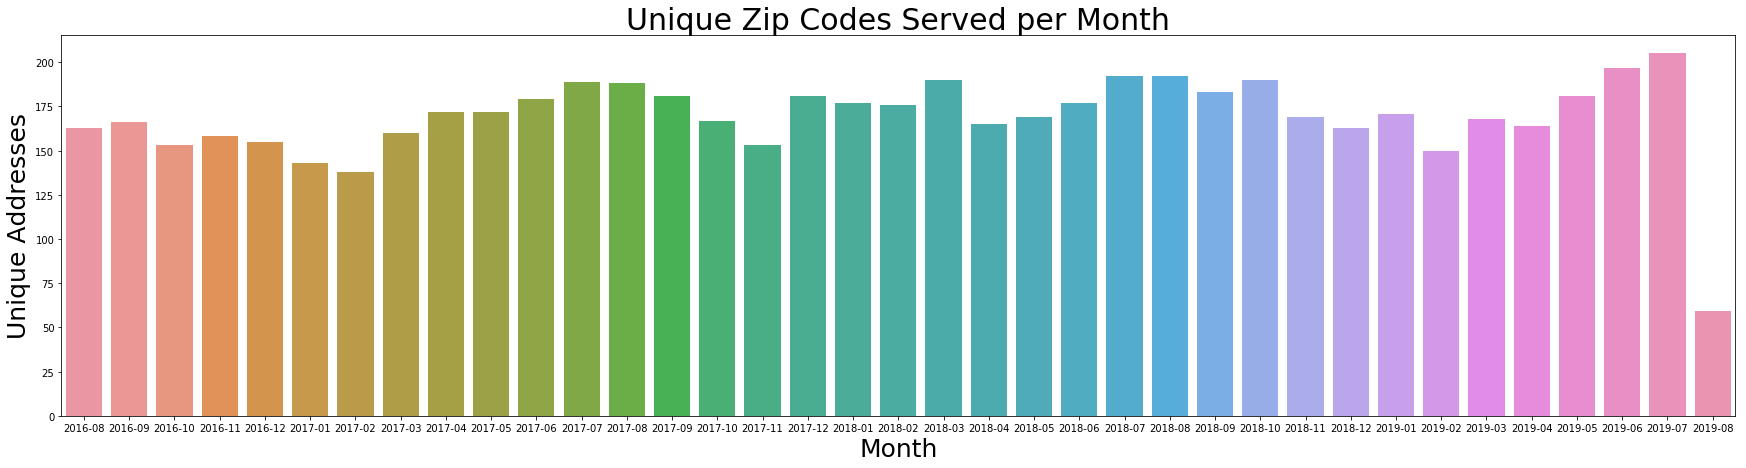

In [69]:
# unique zip codes served per month
x = client_count_df['TransactionDate']
y = client_count_df['client_count']


fig, ax = plt.subplots(figsize=(30,7))
plt.title("Unique Zip Codes Served per Month", fontsize=30)

sns.barplot(x= client_count_df['TransactionDate'], 
             y= client_count_df['Address_Zip'],
             ax=ax)
plt.xlabel('Month', fontsize=25)
plt.ylabel('Unique Addresses', fontsize=25);

In [9]:
#Count total services given by month and drop/rename columns to reflect new aggredated DateFrame
service_given_df = g.count()

service_given_df.drop(['TransactionDate', 
                       'Address_Zip'], 
                      axis=1, 
                      inplace=True)

service_given_df.reset_index(inplace=True)

service_given_df.rename(columns={'clientID': 'services_performed'}, inplace=True)

services_given_df = service_given_df[["TransactionDate", 
                                      "services_performed"]]


services_given_df = services_given_df.rename(columns={"TransactionDate" : "month"})

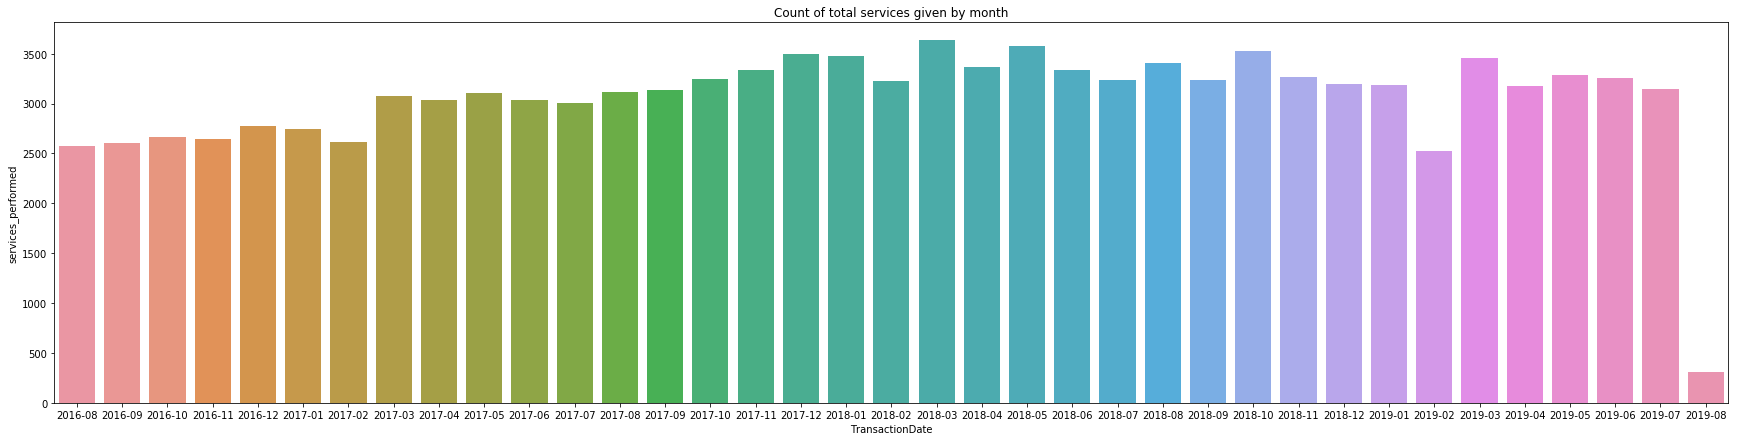

In [249]:
x = services_given_df['month']
y = services_given_df['services_performed']


fig, ax = plt.subplots(figsize=(30,7))
plt.title('Count of total services given by month')
sns.barplot(x= service_given_df['TransactionDate'], 
             y= service_given_df['services_performed'],
             ax=ax);

In [11]:
session_count = client_df.groupby('clientID').nunique()['TransactionDate']

The average number of sessions a client recieves is ~5.5.

The highest number of massages received is 175 by the CEO of the company


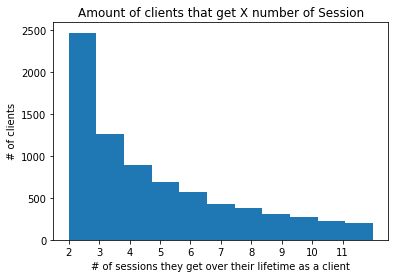

In [85]:
fig, ax = plt.subplots()
ax.hist(session_count, bins=11, range=(2,12))
plt.ylabel('# of clients')
plt.xlabel('# of sessions they get over their lifetime as a client')
plt.title('Amount of clients that get X number of Session')
plt.xticks(ticks=(range(2,12)));

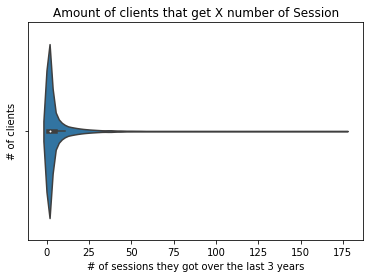

In [102]:
sns.violinplot(session_count, showfliers=False)
plt.ylabel('# of clients')
plt.xlabel('# of sessions they got over the last 3 years')
plt.title('Amount of clients that get X number of Session');

## The average client get 5.5 sessions and sees 2.5 different therapists.
## People tend to get 1.25 hour sessions which is almost split between the 1h and 1.5h offerings we have.

In [13]:
client_df.groupby('clientID').nunique().mean()

TransactionDate     5.567647
clientID            1.000000
Therapist           2.577686
Address_Zip         0.920891
Service_Category    1.075064
HrsWorked           1.242721
dtype: float64

# Mark Clients with Churned or Not Churned for further modeling

In [14]:
def temporal_split(df, start_year=2019, start_month=6, start_day=1, end_year=2019, end_month=8, end_day=1):
    """Needs DataFrame"""
    #cuts the data temporally to the last 2 months so that we can label the data for modeling
    start = client_df['TransactionDate'].searchsorted(dt.datetime(start_year, start_month, start_day))
    end = client_df['TransactionDate'].searchsorted(dt.datetime(end_year, end_month, end_day))

    #DataFrame used as labeling data
    not_churn_df = client_df.iloc[start:end]
    not_churn_df['churn'] = False
    labeling_df = pd.DataFrame(not_churn_df['clientID'].unique())
    labeling_df['churn'] = False
    labeling_df.rename({0 : 'clientID'},axis=1, inplace=True)
    churn_df = client_df.merge(labeling_df, 
                               how='left', 
                               on='clientID')
    churn_df['churn'].fillna(value=True, inplace=True)
    return churn_df

churn_df = temporal_split(client_df)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
churn_df['churn'].fillna(value=True, inplace=True)

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
def temporal_test_split(churn_df, 
                        start_year=2018, 
                        start_month=12, 
                        start_day=1, 
                        end_year=2019, 
                        end_month=5, 
                        end_day=31):
    
    """needs churn_df, outputs temporal test_df for train_test_split"""# Temporal test split
    start = churn_df['TransactionDate'].searchsorted(dt.datetime(start_year, start_month, start_day))
    end = churn_df['TransactionDate'].searchsorted(dt.datetime(end_year, end_month, end_day))
    test_df = churn_df.iloc[start:end]
    return test_df
test_df = temporal_test_split(churn_df)

In [18]:
def temporal_train_split(churn_df, 
                         end_year=2018, 
                         end_month=11, 
                         end_day=30):
    #Temporal train split
    end = churn_df['TransactionDate'].searchsorted(dt.datetime(end_year, end_month, end_day))
    train_df = churn_df.iloc[:end]
    return train_df
train_df = temporal_train_split(churn_df)

In [19]:
train_df.head()

,TransactionDate,clientID,Therapist,Address_Zip,Service_Category,HrsWorked,churn
0,2016-08-02,40156.0,michael jacobus,98109,Massage,1.0,True
1,2016-08-02,60005.0,lauren anderson,98119,Massage,1.0,False
2,2016-08-02,43420.0,stefanie smith,98144,Massage,1.0,False
3,2016-08-02,56100.0,elizabeth panelo,98203,Massage,1.0,False
4,2016-08-02,57367.0,daniel cook,98115,Massage,1.0,True


In [20]:
def aggregate(df, unique_col='clientID', to_aggregate=['TransactionDate', 'Therapist', 'Service_Category']):
    aggregated_df = df.groupby(unique_col).nunique()
    aggregated_df = aggregated_df[to_aggregate]
    return aggregated_df

train_agg_df = aggregate(train_df)
test_agg_df = aggregate(test_df)

In [21]:

# test_df['clientID'].unique()
# weeds_test_df = test_df.groupby('clientID').nunique()
# weeds_test_df = weeds_test_df[['TransactionDate', 
#                                'Therapist', 
#                                'Service_Category']]

In [22]:
churn_df_id_churn = churn_df[['clientID', 
                              'churn']]

In [23]:
# churn or not df for all client IDS, useful for merging
churn_df_id_churn.drop_duplicates(inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
test_merge_df = test_agg_df.merge(churn_df_id_churn, 
                                    how='inner', 
                                    right_on='clientID', 
                                    left_index=True)
test_merge_df.reset_index(inplace=True)
test_merge_df.drop('index', axis=1, inplace=True)

In [25]:
train_merge_df = train_agg_df.merge(churn_df_id_churn, 
                                      how='inner', 
                                      right_on='clientID', 
                                      left_index=True)
train_merge_df.reset_index(inplace=True)
train_merge_df.drop('index', axis=1, inplace=True)
train_target = train_merge_df['churn']

In [142]:
X_train = train_merge_df[['TransactionDate', 'Therapist', 'Service_Category']]
y_train = train_merge_df['churn']
X_test =  test_merge_df[['TransactionDate', 'Therapist', 'Service_Category']]
y_test = test_merge_df['churn']

In [143]:
log_reg = LogisticRegression()

In [144]:
X_test

,TransactionDate,Therapist,Service_Category
0,16,14,1
1,1,1,1
2,2,2,1
3,3,3,1
4,1,1,1
5,1,1,1
6,13,5,1
7,1,1,1
8,2,2,1
9,3,3,1


In [145]:
log_reg.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [146]:
# first model is barely better then just guessing the mean
log_reg.score(X_test, y_test)

0.6720251905866755

In [147]:
y_test.mean()

0.6710308253231687

In [148]:
X_prob = log_reg.predict_proba(X_test)[:, -1]

In [149]:
from sklearn.metrics import roc_auc_score, roc_curve

In [150]:
roc_auc_score(y_test, log_reg.predict(X_test))

0.5016397369005502

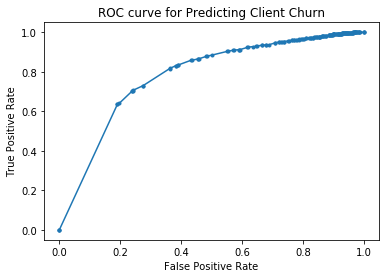

In [151]:
fpr, tpr, thresholds = roc_curve(y_test, X_prob)
plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Predicting Client Churn")
plt.show();

In [86]:
fpr, tpr, thresholds = roc_curve(y_test, X_prob)

2384

In [152]:
log_reg.coef_


array([[-0.06843721, -0.12403717,  0.1309537 ]])

In [153]:
log_reg.predict_proba(X_test)

array([[0.46960354, 0.53039646],
       [0.05948087, 0.94051913],
       [0.07120646, 0.92879354],
       ...,
       [0.05948087, 0.94051913],
       [0.05948087, 0.94051913],
       [0.05948087, 0.94051913]])

In [36]:
# False = client keeps coming to the clinics

,TransactionDate,Therapist,Service_Category
0,16,14,1
1,1,1,1
2,2,2,1
3,3,3,1
4,1,1,1
5,1,1,1
6,13,5,1
7,1,1,1
8,2,2,1
9,3,3,1


In [107]:
ten_or_more_ids = session_count[session_count > 9]
ten_or_more_ids = four_or_more_ids.T
client_history_10_more_df = client_df.merge(four_or_more_ids, how='right', left_on='clientID', right_index=True)
client_history_10_more_df.reset_index(inplace=True)

In [108]:
client_history_10_more_df

,index,TransactionDate_x,clientID,Therapist,Address_Zip,Service_Category,HrsWorked,TransactionDate_y
0,0,2016-08-02,40156.0,michael jacobus,98109,Massage,1.0,20
1,1603,2016-08-19,40156.0,rilla al-haddar,98109,Massage,1.0,20
2,2244,2016-08-26,40156.0,rilla al-haddar,98109,Massage,1.0,20
3,5791,2016-10-05,40156.0,rilla al-haddar,98109,Massage,1.0,20
4,7969,2016-10-28,40156.0,rilla al-haddar,98109,Massage,1.0,20
5,8501,2016-11-04,40156.0,rilla al-haddar,98109,Massage,1.0,20
6,9234,2016-11-11,40156.0,rilla al-haddar,98109,Massage,1.0,20
7,10117,2016-11-21,40156.0,stefanie smith,98109,Massage,1.0,20
8,14138,2017-01-02,40156.0,abigail thomson,98109,Massage,1.0,20
9,14750,2017-01-08,40156.0,dina gosse,98109,Acupuncture,1.0,20


In [109]:
ten_or_more_ids = session_count[session_count > 9]
ten_or_more_ids = pd.DataFrame([ten_or_more_ids])
ten_or_more_ids = ten_or_more_ids.T

In [110]:
client_history_10_more_df = client_df.merge(ten_or_more_ids, how='right', left_on='clientID', right_index=True)
client_history_10_more_df.reset_index(inplace=True)

In [111]:
client_history_10_more_df.drop('index', axis=1, inplace=True)

In [112]:
client_history_10_more_df.rename({'TransactionDate_y' : 'session_count', 'TransactionDate_x' : "date"}, axis=1, inplace=True)

In [113]:
client_history_10_more_df['since_last'] = None

In [114]:
# finds interval lengths for clients who have been in at least 10 times,  O(n) time O(n) space
interval = []
for i in range(0, len(client_history_10_more_df)):
    if client_history_10_more_df.iloc[i]['clientID'] == id:
        diff = client_history_10_more_df.iloc[i]['date'] - client_history_10_more_df.iloc[i-1]['date']
        interval.append(diff)
    else:
        id = client_history_10_more_df.iloc[i]['clientID']
        interval.append(0)

client_history_10_more_df['since_last'] = interval

In [118]:
client_history_10_more_df

,date,clientID,Therapist,Address_Zip,Service_Category,HrsWorked,session_count,since_last
0,2016-08-02,40156.0,michael jacobus,98109,Massage,1.0,20,0
1,2016-08-19,40156.0,rilla al-haddar,98109,Massage,1.0,20,17 days 00:00:00
2,2016-08-26,40156.0,rilla al-haddar,98109,Massage,1.0,20,7 days 00:00:00
3,2016-10-05,40156.0,rilla al-haddar,98109,Massage,1.0,20,40 days 00:00:00
4,2016-10-28,40156.0,rilla al-haddar,98109,Massage,1.0,20,23 days 00:00:00
5,2016-11-04,40156.0,rilla al-haddar,98109,Massage,1.0,20,7 days 00:00:00
6,2016-11-11,40156.0,rilla al-haddar,98109,Massage,1.0,20,7 days 00:00:00
7,2016-11-21,40156.0,stefanie smith,98109,Massage,1.0,20,10 days 00:00:00
8,2017-01-02,40156.0,abigail thomson,98109,Massage,1.0,20,42 days 00:00:00
9,2017-01-08,40156.0,dina gosse,98109,Acupuncture,1.0,20,6 days 00:00:00


In [125]:
client_history_10_more_df['since_last'][0].days

0

In [126]:
def extract_day(x):
    """extract day from the element."""
    if isinstance(x, int):
        return x
    else:
        return x.days

In [127]:
client_history_10_more_df["clean_since_last"] = client_history_10_more_df['since_last'].apply(extract_day)

In [128]:
client_history_10_more_df

,date,clientID,Therapist,Address_Zip,Service_Category,HrsWorked,session_count,since_last,clean_since_last
0,2016-08-02,40156.0,michael jacobus,98109,Massage,1.0,20,0,0
1,2016-08-19,40156.0,rilla al-haddar,98109,Massage,1.0,20,17 days 00:00:00,17
2,2016-08-26,40156.0,rilla al-haddar,98109,Massage,1.0,20,7 days 00:00:00,7
3,2016-10-05,40156.0,rilla al-haddar,98109,Massage,1.0,20,40 days 00:00:00,40
4,2016-10-28,40156.0,rilla al-haddar,98109,Massage,1.0,20,23 days 00:00:00,23
5,2016-11-04,40156.0,rilla al-haddar,98109,Massage,1.0,20,7 days 00:00:00,7
6,2016-11-11,40156.0,rilla al-haddar,98109,Massage,1.0,20,7 days 00:00:00,7
7,2016-11-21,40156.0,stefanie smith,98109,Massage,1.0,20,10 days 00:00:00,10
8,2017-01-02,40156.0,abigail thomson,98109,Massage,1.0,20,42 days 00:00:00,42
9,2017-01-08,40156.0,dina gosse,98109,Acupuncture,1.0,20,6 days 00:00:00,6


In [129]:
grouped_df = client_history_10_more_df.groupby('clientID')['clean_since_last'].mean()

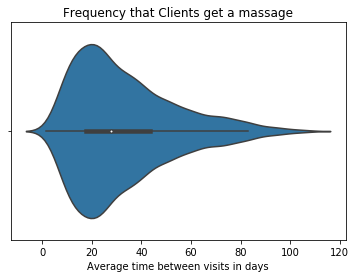

In [140]:
sns.violinplot(grouped_df)
plt.xlabel('Average time between visits in days')
plt.title('Frequency that Clients get a massage');

In [200]:
first_time_df = pd.DataFrame(client_df.groupby('clientID')['TransactionDate'].min())

In [201]:
first_time_df['month'] = first_time_df['TransactionDate'].dt.month

In [202]:
first_time_df['year'] = first_time_df['TransactionDate'].dt.year

In [203]:
count_first_time_by_month_df = first_time_df.groupby(['year', 'month']).count()

In [212]:
count_first_time_by_month_df.reset_index(inplace=True)

In [226]:
count_first_time_by_month_df

,year,month,TransactionDate
0,2016,8,1651
1,2016,9,894
2,2016,10,702
3,2016,11,527
4,2016,12,535
5,2017,1,644
6,2017,2,579
7,2017,3,645
8,2017,4,644
9,2017,5,577


In [220]:
count_first_time_by_month_df.drop('time', axis=1, inplace=True)

In [244]:
count_first_time_by_month_df['datetime']= pd.to_datetime(count_first_time_by_month_df['year'].astype(str) + count_first_time_by_month_df['month'].astype(str), format='%Y%m')

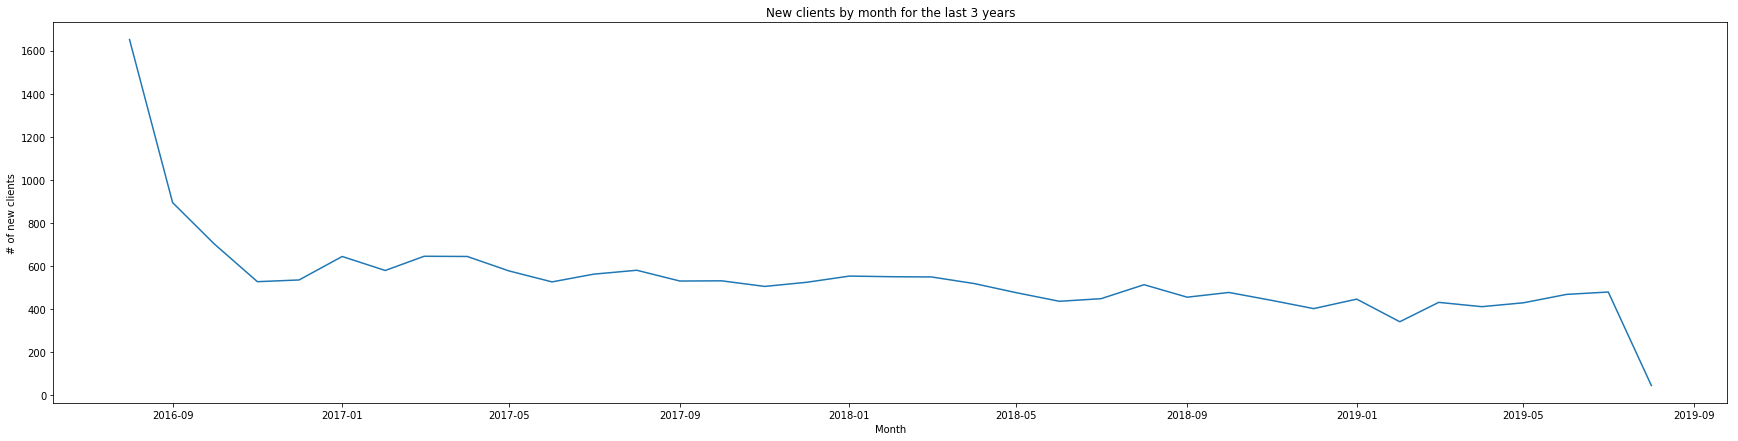

In [250]:


fig, ax = plt.subplots(figsize=(30,7))

sns.lineplot(count_first_time_by_month_df['datetime'], count_first_time_by_month_df['TransactionDate'])
plt.xlabel('Month')
plt.ylabel('# of new clients')
plt.title("New clients by month for the last 3 years");

In [251]:
first_time_df

,TransactionDate,month,year
clientID,,,
1001.0,2016-08-05,8,2016
1030.0,2018-08-10,8,2018
1065.0,2017-06-29,6,2017
1073.0,2017-03-04,3,2017
1075.0,2018-08-25,8,2018
1096.0,2017-01-03,1,2017
1101.0,2017-06-14,6,2017
1107.0,2017-11-19,11,2017
1108.0,2016-12-21,12,2016


In [259]:
th_first_time_df = pd.DataFrame(client_df.groupby('clientID')['Therapist'])

,0,1
0,1001.0,297 michelle jellinghaus 540 ...
1,1030.0,79987 danika drugge 96776 zachary van...
2,1065.0,32626 annie schwartz becker Name: Therapist...
3,1073.0,20210 marianne brennan 90510 ashle...
4,1075.0,81689 corey bedard 84888 dale kelleg...
5,1096.0,14207 elizabeth panelo 16230 jennifer ...
6,1101.0,30993 sarah tivoli 31817 sarah tivoli Na...
7,1107.0,"48340 isak swearingen Name: Therapist, dtyp..."
8,1108.0,13034 leah kirwan 13658 ...
9,1118.0,23344 preston madden 23584 pine crook...
